In [23]:
import pandas as pd
import difflib
import datetime
import dateutil

import xgboost
import category_encoders as ce
import scipy.stats as stats
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import  root_mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import json
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from carly import outlier_detection

# Load the autoreload extension
%load_ext autoreload

# Set autoreload to automatically reload modules before executing code
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_df_RAW = pd.read_csv("../dataset/train.csv")
test_df_RAW = pd.read_csv("../dataset/test.csv")

combined_df = pd.concat([train_df_RAW, test_df_RAW], ignore_index=True)

In [3]:
# GLOBAL VARIABLES
IMPUTERS = {}

# Create mapping for fuel type from model make
fuel_type_mapping = combined_df.groupby(['make', 'model'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
FUEL_TYPE_DICT = dict(zip(zip(fuel_type_mapping['make'], fuel_type_mapping['model']), fuel_type_mapping['fuel_type']))

In [4]:
def DEDUP_listingid(df):
    
    df['listing_id']    = df['listing_id'].astype(int).astype(str).str.strip()
    df                  = df.drop_duplicates('listing_id')

    return (df)
    
def FIXNULL_make(df): 

    df['make']          = df['make'].str.upper()
    df['make']          = df['make'].str.replace(' ','').str.strip()
    df['title']         = df['title'].str.upper()
    
    make_list           = [make for make in df['make'].unique().tolist() if type(make) == str]
    df['make_temp']     = df['title'].str.split(' ').str[0]
    df['make_temp']     = df.apply(lambda x: difflib.get_close_matches(x['make_temp'], make_list, n=1)[0], axis=1)
    df['make']          = df['make'].fillna(df['make_temp'])
    df                  = df.drop(columns = 'make_temp')

    return (df)

def FIXNULL_manufacture(df):

    df['original_reg_date']         = pd.to_datetime(df['original_reg_date'], format = "%d-%b-%Y")
    df['reg_date']                  = pd.to_datetime(df['reg_date'], format = "%d-%b-%Y")
    
    df['original_reg_date_temp']    = df['original_reg_date'].dt.year
    df['reg_date_temp']             = df['reg_date'].dt.year
    df['manufactured']              = df['manufactured'].fillna(df[['original_reg_date_temp','reg_date_temp']].min(axis=1))
    df['manufactured']              = df['manufactured'].astype(int).astype(str)
    df                              = df.drop(columns = ['original_reg_date_temp', 'reg_date_temp'])
    
    return (df)

def FIXNULL_ownercount(df):
    
    df['no_of_owners'] = df['no_of_owners'].fillna(1)
    
    return df

def FIXNULL_dereg(df):
    df['dereg_value'] = df['dereg_value'].fillna(0)
    return(df)

def FIXNULL_fueltype(df):
    # Extract fuel type from category
    fuel_keywords = {
        'electric': 'electric',
        'hybrid': 'petrol-electric'
    }

    def extract_fuel_type(category_text):
        category_text = category_text.lower()  
        for keyword, fuel_type in fuel_keywords.items():
            if keyword in category_text:
                return fuel_type
        return None
    
    df['fuel_type_category_fill'] = df['fuel_type']

    df.loc[df['fuel_type'].isna(), 'fuel_type_category_fill'] = df['category'].apply(extract_fuel_type)

    # Define a function to fill missing fuel types
    def fill_fuel_type(row):
        if pd.isna(row['fuel_type']):
            return FUEL_TYPE_DICT.get((row['make'], row['model']), None)
        return row['fuel_type']

    # Apply the function to fill in missing values
    df['fuel_type_model_make_fill'] = df['fuel_type']
    df.loc[df['fuel_type'].isna(), 'fuel_type_model_make_fill']  = df.apply(fill_fuel_type, axis=1)

    df['fuel_type'] = df['fuel_type_model_make_fill']
    df = df.drop(columns=['fuel_type_model_make_fill', 'fuel_type_category_fill'])

    return df

def ENCODE_category(df, drop = True):
    
    df_temp             = df['category'].str.split(',', expand = True)
    df_temp             = df_temp.astype(str)
    category_set        = set(sum(df['category'].str.split(',').tolist(), []))
    category_set        = set([category.strip() for category in category_set if len(category.strip()) > 1])
    category_dflist     = [df_temp.apply(lambda x: sum(x.str.contains(category)), axis=1).rename(f"CAT-{category.replace(' ','')}") for category in category_set]
    df                  = pd.concat([df]+category_dflist, axis = 1)
    df                  = df.drop(columns = ['category'])

    df['CAT-coeparf'] = df['CAT-coecar'].astype(str).str.replace('1','COE').str.replace('0', 'PARF')
    df['CAT-elechybrid'] = df['CAT-hybridcars'].astype(str).str.replace('1','HYBRID').str.replace('0', 'ELEC')

    if drop == True:
        df = df.drop(columns = ['CAT-electriccars','CAT-hybridcars','CAT-coecar', 'CAT-parfcar',])
        
    return (df)

def ENCODE_transmission(df, drop=True):
    
    df['TRANSMISSION-manual'] = pd.get_dummies(df['transmission'], drop_first=True, dtype=int)
    
    if drop == True:
        df              = df.drop(columns = ['transmission'])
    
    return (df)

def ENCODE_vehtype(df, drop=True):

    df['type_of_vehicle'] = df['type_of_vehicle'].str.upper().str.strip().str.replace(' ','')
    encoder             = ce.BinaryEncoder(cols='type_of_vehicle',return_df=True)
    df_temp             = encoder.fit_transform(df['type_of_vehicle']) 
    df_temp.columns     = [col.replace('type_of_vehicle_', "TYPE-binenc") for col in df_temp.columns] 

    df                  = pd.concat([df, df_temp], axis = 1)

    if drop == True:
        df                  = df.drop(columns = 'type_of_vehicle')

    return df

def ENCODE_make(df, drop=True):

    encoder             = ce.BinaryEncoder(cols='make',return_df=True)
    df_temp             = encoder.fit_transform(df['make']) 
    df_temp.columns     = [col.replace('make_', "MAKE-binenc") for col in df_temp.columns] 

    df = pd.concat([df, df_temp], axis =1)

    if drop==True:
        df = df.drop(columns = ['make'])
    
    return(df)

def ENCODE_opcscheme(df): 
    df.loc[~(df['opc_scheme'].isnull()),'opc_scheme'] = 1
    df['opc_scheme'] = df['opc_scheme'].fillna(0)

    return df

def ENCODE_fueltype(df, drop=True):

    df['fuel_type'] = df['fuel_type'].fillna('unknown').str.upper().str.strip()
    encoder         = ce.BinaryEncoder(cols='fuel_type',return_df=True)
    df_temp         = encoder.fit_transform(df['fuel_type']) 
    df_temp.columns = [col.replace('fuel_type_', "FUEL-binenc") for col in df_temp.columns] 

    df = pd.concat([df, df_temp], axis = 1)

    if drop==True:
        df = df.drop(columns = 'fuel_type')

    return df

def ENCODE_model(df, drop=True):

    df['model']     = df['model'].str.upper()
    
    encoder         = ce.BinaryEncoder(cols='model',return_df=True)
    df_temp         = encoder.fit_transform(df['model']) 
    df_temp.columns = [col.replace('model_', "MODEL-binenc") for col in df_temp.columns] 
    df              = pd.concat([df, df_temp], axis = 1)

    if drop==True:
        df = df.drop(columns = 'model')

    return df

def EXTRACT_features(df):

    df['features'] = df['features'].astype(str).str.upper()
    
    df.loc[(df['features'].str.contains('4 CYLINDER')) | (df['features'].str.contains('4-CYLINDER')) | (df['features'].str.contains('FOUR CYLINDER')), 'FEAT-CYLcount'] = 4
    df.loc[(df['features'].str.contains('5 CYLINDER')) | (df['features'].str.contains('5-CYLINDER')) | (df['features'].str.contains('FIVE CYLINDER')), 'FEAT-CYLcount'] = 5
    df.loc[(df['features'].str.contains('6 CYLINDER')) | (df['features'].str.contains('6-CYLINDER')) | (df['features'].str.contains('SIX CYLINDER')), 'FEAT-CYLcount'] = 6
    df['FEAT-CYLcount'] = df['FEAT-CYLcount'].fillna(0).astype(int)
    
    df['FEAT-brakehp'] = df['features'].str.extract('(\d+)(?:BHP| BHP)') 
    df['FEAT-torque'] = df['features'].str.extract('(\d+)(?:NM| NM)') 
    df['FEAT-valve'] = df['features'].str.extract('(\d+)(?:VALVE| VALVE)') 

    df.loc[(df['features'].str.contains('TURBOCHARGED')) | (df['features'].str.contains('SUPERCHARGED')), 'FEAT-charged_engine'] = 1
    df['FEAT-charged_engine'] = df['FEAT-charged_engine'].fillna(0).astype(int)
    
    df.loc[df['features'].str.contains('SRS'), 'FEAT-srs_airbag'] = 1
    df['FEAT-srs_airbag'] = df['FEAT-srs_airbag'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('KEYLESS'), 'FEAT-keyless_ss'] = 1
    df['FEAT-keyless_ss'] = df['FEAT-keyless_ss'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('GUARANTEE'), 'FEAT-guarantee'] = 1
    df['FEAT-guarantee'] = df['FEAT-guarantee'].fillna(0).astype(int)
    
    df.loc[df['features'].str.contains('AWD'), 'FEAT-awd'] = 1
    df['FEAT-awd'] = df['FEAT-awd'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('4WD'), 'FEAT-4wd'] = 1
    df['FEAT-4wd'] = df['FEAT-4wd'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('RWD'), 'FEAT-rwd'] = 1
    df['FEAT-rwd'] = df['FEAT-rwd'].fillna(0).astype(int)
    df.loc[df['features'].str.contains('FWD'), 'FEAT-fwd'] = 1
    df['FEAT-fwd'] = df['FEAT-fwd'].fillna(0).astype(int)
    
    df = df.drop(columns = 'features')
    
    return df

def EXTRACT_desc(df): 
    df['description'] = df['description'].astype(str).str.upper()

    df.loc[df['description'].str.contains('LOAN'), 'DESC-loan'] = 1
    df['DESC-loan'] = df['DESC-loan'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('MAINTAINED'), 'DESC-maintained'] = 1
    df['DESC-maintained'] = df['DESC-maintained'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('ACCIDENT FREE'), 'DESC-accifree'] = 1
    df['DESC-accifree'] = df['DESC-accifree'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('WARRANTY'), 'DESC-warranty'] = 1
    df['DESC-warranty'] = df['DESC-warranty'].fillna(0).astype(int)

    df.loc[df['description'].str.contains('TRADE IN'), 'DESC-tradein'] = 1
    df['DESC-tradein'] = df['DESC-tradein'].fillna(0).astype(int)

    df = df.drop(columns = 'description')

    return df

def EXTRACT_accessories(df): 
    df['accessories'] = df['accessories'].astype(str).str.upper()

    df.loc[df['accessories'].str.contains('INSPECTION'), 'ACCESS-inspection'] = 1
    df['ACCESS-inspection'] = df['ACCESS-inspection'].fillna(0).astype(int)

    df.loc[df['accessories'].str.contains('AUDIO'), 'ACCESS-audio'] = 1
    df['ACCESS-audio'] = df['ACCESS-audio'].fillna(0).astype(int)

    df.loc[df['accessories'].str.contains('CAMERA'), 'ACCESS-camera'] = 1
    df['ACCESS-camera'] = df['ACCESS-camera'].fillna(0).astype(int)

    df.loc[(df['accessories'].str.contains('SPORT RIM')) | (df['accessories'].str.contains('SPORTS RIM')) , 'ACCESS-sportrim'] = 1
    df['ACCESS-sportrim'] = df['ACCESS-sportrim'].fillna(0).astype(int)
    
    df = df.drop(columns = 'accessories')

    return df



def CALC_currentage(df):
    
    df['AGE-currentMANU'] = datetime.datetime.now().year - df['manufactured'].astype(int)

    df['reg_date_temp']   = df['original_reg_date'].fillna(df['reg_date'])
    df['AGE-currentREG']  = df.apply(lambda x: dateutil.relativedelta.relativedelta(x['reg_date_temp'], datetime.datetime.now()).months, axis=1)
    df = df.drop(columns = ['reg_date_temp',])

    return(df)

def CALC_remainage(df):

    df['title'] = df['title'].str.upper()

    df.loc[df['title'].str.contains('COE'), 'coe_temp'] = df['title'].str.split(' ').str[-1]
    df['coe_temp1']         = df['coe_temp'].str.replace(')','')
    df['coe_temp1']         = pd.to_datetime(df['coe_temp1'], format = "%m/%Y",errors='coerce')
    df['coe_temp2']         = df[['original_reg_date', 'reg_date']].max(axis = 1) + pd.offsets.DateOffset(years=10)
    df['coe_enddate']       = df['coe_temp1'].fillna(df['coe_temp2'])
    df['AGE-remaining']     = df.apply(lambda x: dateutil.relativedelta.relativedelta(x['coe_enddate'], datetime.datetime.now()).years, axis=1)
    df                      = df.drop(columns = ["coe_temp", "coe_temp1", "coe_temp2", "coe_enddate"])

    return df

def IMPUTENULL_power(df):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',]
    df_temp = df[related_cols + ['power']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['power'] = df['power'].fillna(df_temp[0])

    return df

def IMPUTENULL_curbweight(df):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',]
    df_temp = df[related_cols + ['curb_weight']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['curb_weight'] = df['curb_weight'].fillna(df_temp[0])

    return df

def IMPUTENULL_enginecap(df):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',]
    df_temp = df[related_cols + ['engine_cap']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['engine_cap'] = df['engine_cap'].fillna(df_temp[0])

    return df

def IMPUTENULL_depreciation(df):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',            
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['depreciation']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['depreciation'] = df['depreciation'].fillna(df_temp[0])

    return df

def IMPUTENULL_arf(df):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['arf']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['arf'] = df['arf'].fillna(df_temp[0])

    return df

def IMPUTENULL_omv(df):
    related_cols =  ['TRANSMISSION-manual',
                     'TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['omv']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['omv'] = df['omv'].fillna(df_temp[0])

    return df

def IMPUTENULL_mileage(df):
    related_cols =  ['TRANSMISSION-manual',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['mileage']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['mileage'] = df['mileage'].fillna(df_temp[0])

    return df

def IMPUTENULL_roadtax(df):
    related_cols =  ['TYPE-binenc0',
                     'TYPE-binenc1',
                     'TYPE-binenc2',
                     'TYPE-binenc3',
                     'MAKE-binenc0',
                     'MAKE-binenc1',
                     'MAKE-binenc2',
                     'MAKE-binenc3',
                     'MAKE-binenc4',
                     'MAKE-binenc5',
                     'MAKE-binenc6',
                     'MODEL-binenc0',
                     'MODEL-binenc1',
                     'MODEL-binenc2',
                     'MODEL-binenc3',
                     'MODEL-binenc4',
                     'MODEL-binenc5',
                     'MODEL-binenc6',
                     'MODEL-binenc7',
                     'MODEL-binenc8',
                     'MODEL-binenc9',
                     'AGE-currentMANU',
                     'AGE-remaining'
                    ]
    df_temp = df[related_cols + ['road_tax']]
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_temp = imputer.fit_transform(df_temp)
    df_temp = pd.DataFrame(df_temp[:,-1])
    df['road_tax'] = df['road_tax'].fillna(df_temp[0])

    return df

def RATIO_ownertoage(df):
    df['OWNER-to-AGEcurrent'] = df['no_of_owners'] / df['AGE-currentMANU']
    df.loc[df['OWNER-to-AGEcurrent'] == np.inf, 'OWNER-to-AGEcurrent'] = 1
    return df

def RATIO_miletoage(df):
    df['MILEAGE-to-AGEcurrent'] = df['mileage'] / df['AGE-currentMANU']
    df.loc[df['MILEAGE-to-AGEcurrent'] == np.inf, 'MILEAGE-to-AGEcurrent'] = df['mileage']
    return df

def RATIO_miletoowner(df):
    df['MILEAGE-to-OWNER'] = df['mileage'] / df['no_of_owners']

    return df

def RATIO_curbtopower(df):
    df['CURB-to-POWER'] = df['curb_weight'] / df['power']
    df.loc[df['CURB-to-POWER'] == np.inf, 'CURB-to-POWER'] = df[~df['CURB-to-POWER'].isnull()]['CURB-to-POWER'].min()
    return(df)
    
def RATIO_indirectcost(df):    
    df['INDIRECTcost'] = df['AGE-remaining'] * (df['road_tax'] + df['depreciation']) - df['dereg_value']
    return(df)

def RATIO_ARFtoOMV(df):    
    df['ARF-to-OMV'] = df['arf'] / df['omv']
    return(df)

def RATIO_ARFtoDEREG(df):    
    df['ARF-to-DEREG'] = df['arf'] / df['dereg_value']
    df.loc[df['ARF-to-DEREG'] == np.inf, 'ARF-to-DEREG'] = 0
    
    return(df)


ENCODED_feature_list = ['curb_weight',
                        'power',
                        'engine_cap',
                        'no_of_owners',
                        'depreciation',
                        'coe',
                        'road_tax',
                        'dereg_value',
                        'mileage',
                        'omv',
                        'arf',
                        'opc_scheme',
                        
                        'CAT-electriccars',
                        'CAT-hybridcars',
                        'CAT-coecar', 
                        'CAT-parfcar', 
                        'CAT-lowmileagecar',
                        'CAT-directownersale',
                        'CAT-consignmentcar',     
                        'CAT-importedusedvehicle',
                        'CAT-premiumadcar',
                        'CAT-sgcarmartwarrantycars',
                        'CAT-staevaluatedcar',
                        'CAT-almostnewcar',
                        'CAT-rare&exotic',
                        'CAT-vintagecars',
                        
                        'TRANSMISSION-manual',
                        'TYPE-binenc0',
                        'TYPE-binenc1',
                        'TYPE-binenc2',
                        'TYPE-binenc3',
                        'MAKE-binenc0',
                        'MAKE-binenc1',
                        'MAKE-binenc2',
                        'MAKE-binenc3',
                        'MAKE-binenc4',
                        'MAKE-binenc5',
                        'MAKE-binenc6',
                        'FUEL-binenc0',
                        'FUEL-binenc1',
                        'FUEL-binenc2',
                        'MODEL-binenc0',
                        'MODEL-binenc1',
                        'MODEL-binenc2',
                        'MODEL-binenc3',
                        'MODEL-binenc4',
                        'MODEL-binenc5',
                        'MODEL-binenc6',
                        'MODEL-binenc7',
                        'MODEL-binenc8',
                        'MODEL-binenc9',
                        'FEAT-charged_engine',
                        'FEAT-srs_airbag',
                        'FEAT-keyless_ss',
                         'FEAT-guarantee',
                         'FEAT-awd',
                         'FEAT-4wd',
                         'FEAT-rwd',
                         'FEAT-fwd',
                         'DESC-loan',
                         'DESC-maintained',
                         'DESC-accifree',
                         'DESC-warranty',
                         'DESC-tradein',
                         'ACCESS-inspection',
                         'ACCESS-audio',
                         'ACCESS-camera',
                         'ACCESS-sportrim',
                        'AGE-currentMANU',
                        #'AGE-currentREG',
                        'AGE-remaining',
                        'OWNER-to-AGEcurrent',
                        'MILEAGE-to-AGEcurrent',
                        'MILEAGE-to-OWNER',
                        'CURB-to-POWER',
                        'INDIRECTcost',
                        'ARF-to-OMV',
                        'ARF-to-DEREG',]

CAT_feature_list = ['curb_weight',
                    'power',
                    'engine_cap',
                    'no_of_owners',
                    'depreciation',
                    'coe',
                    'road_tax',
                    'dereg_value',
                    'mileage',
                    'omv',
                    'arf',
                    'opc_scheme',
                    
                    'CAT-elechybrid',
                    'CAT-coeparf',
                    'CAT-lowmileagecar',
                    'CAT-directownersale',
                    'CAT-consignmentcar',     
                    'CAT-importedusedvehicle',
                    'CAT-premiumadcar',
                    'CAT-sgcarmartwarrantycars',
                    'CAT-staevaluatedcar',
                    'CAT-almostnewcar',
                    'CAT-rare&exotic',
                    'CAT-vintagecars',
                    
                    'TRANSMISSION-manual',
                    'make',
                    'type_of_vehicle',
                    'fuel_type',
                    'model',
                    
                    'FEAT-charged_engine',
                    'FEAT-srs_airbag',
                    'FEAT-keyless_ss',
                     'FEAT-guarantee',
                     'FEAT-awd',
                     'FEAT-4wd',
                     'FEAT-rwd',
                     'FEAT-fwd',
                     'DESC-loan',
                     'DESC-maintained',
                     'DESC-accifree',
                     'DESC-warranty',
                     'DESC-tradein',
                     'ACCESS-inspection',
                     'ACCESS-audio',
                     'ACCESS-camera',
                     'ACCESS-sportrim',
                    'AGE-currentMANU',
                    #'AGE-currentREG',
                    'AGE-remaining',
                    'OWNER-to-AGEcurrent',
                    'MILEAGE-to-AGEcurrent',
                    'MILEAGE-to-OWNER',
                    'CURB-to-POWER',
                    'INDIRECTcost',
                    'ARF-to-OMV',
                    'ARF-to-DEREG',]

target = 'price'

def model_preprocessing(input_df):
    
    input_df = input_df.drop(columns = ['eco_category', # same value for all records
                                        'indicative_price', # same value for all records
                                        'lifespan', #more than 90% of records null values 
                                       ])
    
    ####################### data processing ######################
    #####################################################################
    
    input_df = DEDUP_listingid(df = input_df)
    
    input_df = FIXNULL_make(df = input_df)
    input_df = FIXNULL_manufacture(df = input_df)
    input_df = FIXNULL_ownercount(df = input_df)
    input_df = FIXNULL_dereg(df = input_df)
    input_df = FIXNULL_fueltype(df = input_df)
    
    input_df = ENCODE_category(df = input_df, drop = False)
    input_df = ENCODE_transmission(df = input_df, drop=True)
    input_df = ENCODE_vehtype(df=input_df, drop=False)
    input_df = ENCODE_make(df=input_df, drop=False)
    input_df = ENCODE_fueltype(df=input_df, drop=False)
    input_df = ENCODE_model(df=input_df, drop=False)
    input_df = ENCODE_opcscheme(df=input_df)
    
    input_df = EXTRACT_features(df = input_df)
    input_df = EXTRACT_desc(df = input_df)
    input_df = EXTRACT_accessories(df = input_df)
    
    input_df = CALC_currentage(df = input_df)
    input_df = CALC_remainage(df = input_df)
    
    input_df = IMPUTENULL_power(df=input_df)
    input_df = IMPUTENULL_curbweight(df=input_df)
    input_df = IMPUTENULL_enginecap(df=input_df)
    input_df = IMPUTENULL_depreciation(df=input_df)
    input_df = IMPUTENULL_omv(df=input_df)
    input_df = IMPUTENULL_arf(df=input_df)
    input_df = IMPUTENULL_mileage(df=input_df)
    input_df = IMPUTENULL_roadtax(df=input_df)
    
    input_df = RATIO_ownertoage(df=input_df)
    input_df = RATIO_miletoage(df=input_df)
    input_df = RATIO_curbtopower(df=input_df)
    input_df = RATIO_indirectcost(df=input_df)
    input_df = RATIO_ARFtoOMV(df=input_df)
    input_df = RATIO_ARFtoDEREG(df=input_df)
    input_df = RATIO_miletoowner(df=input_df)

    cat_features = ["make", "type_of_vehicle", "fuel_type", "model", "CAT-elechybrid", "CAT-coeparf",]
    input_df[cat_features] = input_df[cat_features].astype('category')
    
    return input_df

In [5]:
train_df_RAW = pd.read_csv(r"../dataset/train.csv")
test_df_RAW = pd.read_csv(r"../dataset/test.csv")

####################### basic data definitions ######################
#####################################################################
# listing_id          - the unique id for the listing of a used car OK
# title               - title of the listing; free text attribute typically containing the make, model, engine type/size
# make                - make/brand of the car OK
# model               - model of the car (for the given make/brand) NOT SURE
# description         - title of the listing; free text attribute NOT SURE
# manufactured        - Year the car was manufactured OK
# original_reg_date   - Original registration data; date format string 
# reg_date            - Registration data; date format string
# type_of_vehicle     - Type of vehicle (e.g., "sports car", "luxury sedan")
# category            - Category of the car; list of categories, comma-separated
# transmission        - Type of transmission ("auto" or "manual")
# curb_weight         - Weight in kg of the vehicle without any passenger or items
# power               - Power of engine in kW
# fuel_type           - Fuel type (e.g, "petrol", "diesel", "electric")
# engine_cap          - Displacement of engine in cc (cubic centimeter)
# no_of_owners        - Number of previous owners (>=1 since all cars are used)
# depreciation        - Annual depreciation in SGD is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span
# coe                 - Certificate of entitlement value in SGD when first registered
# road_tax            - Road tax value in SGD calculated based on the engine capacity on a per annum basis
# dereg_value         - deregistration value in SGD one will get back from the government upon deregistering the vehicle for use in Singapore
# mileage             - Number of kilometers driven
# omv                 - Open Market Value in SGD assessed by the Singapore Customs
# arf                 - Additional Registration Fee in SGD is a tax imposed upon registration of a vehicle
# opc_scheme          - Off-peak car scheme
# lifespan            - Date stated on the lifespan marks the day that the vehicle must be deregistered
# eco_category        - Eco category of vehicle
# features            - Noteworthy features; free text attribute
# accessories         - Noteworthy accessories ; free text attribute
# indicative_price    - General guide to the price in SGD of the vehicle
# price               - Resale price in SGD of the car

train_df = model_preprocessing(input_df = train_df_RAW)
test_df = model_preprocessing(input_df = test_df_RAW)

/var/folders/hb/fc2wl4fj6937fsp_ld61fq1c0000gn/T/ipykernel_93882/64693304.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['opc_scheme'] = df['opc_scheme'].fillna(0)
/var/folders/hb/fc2wl4fj6937fsp_ld61fq1c0000gn/T/ipykernel_93882/64693304.py:134: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['opc_scheme'] = df['opc_scheme'].fillna(0)


### Remove outliers from training dataset

In [6]:
train_df = train_df.loc[~(train_df['AGE-remaining']<0) | ~(train_df['AGE-currentREG']<0)]
len(train_df)

24995

Number of components to retain 90% variance: 51


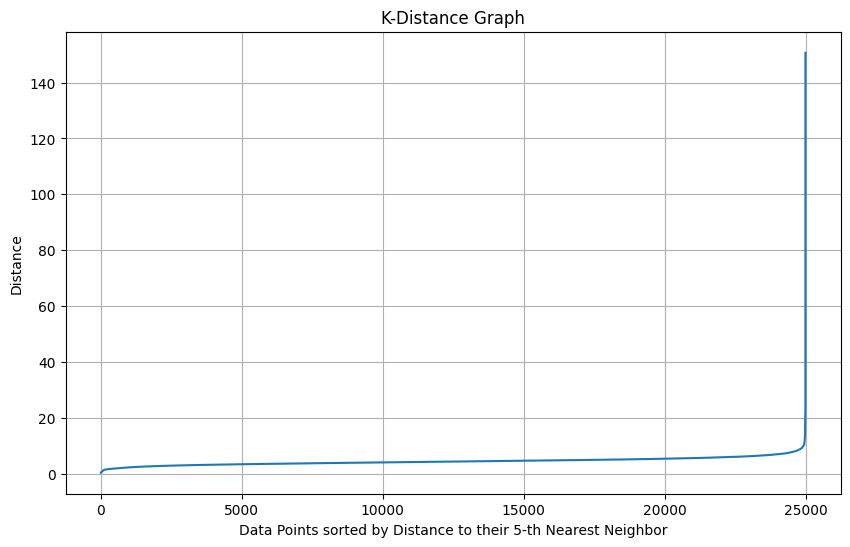

Anomalies found: 259


,listing_id,title,make,model,manufactured,original_reg_date,reg_date,type_of_vehicle,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,price,CAT-rare&exotic,CAT-sgcarmartwarrantycars,CAT-hybridcars,CAT-coecar,CAT-parfcar,CAT-staevaluatedcar,CAT-premiumadcar,CAT-opccar,CAT-importedusedvehicle,CAT-electriccars,CAT-consignmentcar,CAT-lowmileagecar,CAT-vintagecars,CAT-directownersale,CAT-almostnewcar,CAT-coeparf,CAT-elechybrid,TRANSMISSION-manual,TYPE-binenc0,TYPE-binenc1,TYPE-binenc2,TYPE-binenc3,MAKE-binenc0,MAKE-binenc1,MAKE-binenc2,MAKE-binenc3,MAKE-binenc4,MAKE-binenc5,MAKE-binenc6,FUEL-binenc0,FUEL-binenc1,FUEL-binenc2,MODEL-binenc0,MODEL-binenc1,MODEL-binenc2,MODEL-binenc3,MODEL-binenc4,MODEL-binenc5,MODEL-binenc6,MODEL-binenc7,MODEL-binenc8,MODEL-binenc9,FEAT-CYLcount,FEAT-brakehp,FEAT-torque,FEAT-valve,FEAT-charged_engine,FEAT-srs_airbag,FEAT-keyless_ss,FEAT-guarantee,FEAT-awd,FEAT-4wd,FEAT-rwd,FEAT-fwd,DESC-loan,DESC-maintained,DESC-accifree,DESC-warranty,DESC-tradein,ACCESS-inspection,ACCESS-audio,ACCESS-camera,ACCESS-sportrim,AGE-currentMANU,AGE-currentREG,AGE-remaining,OWNER-to-AGEcurrent,MILEAGE-to-AGEcurrent,CURB-to-POWER,INDIRECTcost,ARF-to-OMV,ARF-to-DEREG,MILEAGE-to-OWNER,cluster
42,1322689,ISUZU CYZ52K TIPPER (COE TILL 08/2027),ISUZU,CYZ52K,2012,NaT,2012-10-10,TRUCK,11800.0,51.158433,DIESEL,15681.0,1.0,25730.0,26442,901.75065,16155.0,270237.0,102219.000000,5111.000000,0,78600.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,COE,ELEC,1,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,2,0.083333,22519.750000,230.656008,37108.5013,0.050000,0.316373,270237.0,-1
84,1317904,BENTLEY CONTINENTAL GT 4.0A V8 (COE TILL 02/2031),BENTLEY,CONTINENTAL,2013,NaT,2013-12-11,SPORTSCAR,2295.0,373.000000,UNKNOWN,3993.0,5.0,28640.0,45586,4334.00000,30212.0,108000.0,172046.000000,281683.000000,0,189800.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,COE,ELEC,0,0,1,0,1,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,500,670,NaN,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,1,0,11,-10,6,0.454545,9818.181818,6.152815,167632.0000,1.637254,9.323547,21600.0,-1
92,1330766,FERRARI 328 GTB (COE TILL 12/2025),FERRARI,328,1986,NaT,1986-09-01,SPORTSCAR,1554.4,456.000000,UNKNOWN,3185.0,5.0,276380.0,59798,280.00000,7962.0,45000.0,37398.408457,56579.888917,0,368000.0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,COE,ELEC,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,NaN,304,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,-2,1,0.131579,1184.210526,3.408772,268698.0000,1.512896,7.106241,9000.0,-1
324,1236230,FERRARI CALIFORNIA T 3.8A,FERRARI,CALIFORNIA,2014,NaT,2015-01-06,SPORTSCAR,1770.0,412.000000,UNKNOWN,3855.0,4.0,514250.0,74389,3724.00000,203330.0,28500.0,236858.000000,398345.000000,0,488000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,PARF,ELEC,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,NaN,755,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,10,-10,0,0.400000,2850.000000,4.296117,-203330.0000,1.681788,1.959106,7125.0,-1
330,1316819,IVECO MLL190EL25,IVECO,MLL190EL25,2016,NaT,2017-12-28,TRUCK,8740.0,0.000000,DIESEL,5880.0,1.0,14430.0,57701,853.60000,19919.0,66062.0,71229.000000,3562.000000,0,49800.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,PARF,ELEC,0,0,1,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,1,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,-10,3,0.125000,8257.750000,2.136054,25931.8000,0.050008,0.178824,66062.0,-1


In [7]:
outlier_df = outlier_detection.identify_outliers(df=train_df)
outlier_df[outlier_df['cluster']==-1].head()

In [8]:
train_df = outlier_df.loc[(outlier_df['cluster']!=-1) & (outlier_df['CAT-rare&exotic']!=1)].drop(columns=['cluster'])
print(len(train_df))

23884


### Bayesian Search

In [9]:
train_df_base, train_df_eval = train_test_split(train_df, test_size=0.2, random_state=888888)

In [15]:
####################### hyperparameters tuning ######################
#####################################################################
from skopt import BayesSearchCV
# Define the hyperparameter distributions
param_dist = {
            'n_estimators'      : (300,  2000),
            'max_depth'         : (3, 200),
            'learning_rate'     : (0.01, 0.1, "log-uniform"),
            'gamma'             : (0.01, 0.9),    
            'alpha'             : (0.01, 0.1),     
            
            'subsample'         : (0.3, 0.7),
            'colsample_bytree'  : (0.3, 0.7),
            'early_stopping_rounds' : (8, 18), 
            'min_child_weight'  : (3, 88),   
            }

xgb_model = xgboost.XGBRegressor(random_state = 888888, 
                                 n_jobs = -1)

# Create the RandomizedSearchCV object
random_search = BayesSearchCV(xgb_model, 
                                   search_spaces  = param_dist, 
                                   n_iter               = 88, 
                                   cv                   = 5, 
                                   random_state         = 888888,
                                   scoring              = 'neg_root_mean_squared_error', 
                                  )
# Fit the RandomizedSearchCV object to the training data
random_search.fit(train_df_base[ENCODED_feature_list], train_df_base[target],
                 eval_set=[(train_df_eval[ENCODED_feature_list], train_df_eval[target],)], verbose = False)

ENCODED_random_search_df = pd.DataFrame(random_search.cv_results_)
ENCODED_random_search_df = ENCODED_random_search_df[[ 'params',
                                     'split0_test_score',
                                     'split1_test_score',
                                     'split2_test_score',
                                     'split3_test_score',
                                     'split4_test_score',
                                     'mean_test_score',
                                     'std_test_score',
                                     'rank_test_score']]

ENCODED_random_search_df['objfunc'] = ENCODED_random_search_df[['split0_test_score',
                                                'split1_test_score',
                                                'split2_test_score',
                                                'split3_test_score',
                                                'split4_test_score',]].median(axis=1)
ENCODED_random_search_df = ENCODED_random_search_df.sort_values('objfunc', ascending = False)
ENCODED_random_search_df.head()

KeyboardInterrupt: 

In [10]:
name = "bayesian"

In [11]:
best_params ={'alpha': 0.07272769267361982,
             'colsample_bytree': 0.5004695925119211,
             'early_stopping_rounds': 18,
             'gamma': 0.33307638017245794,
             'learning_rate': 0.014079290196807495,
             'max_depth': 52,
             'min_child_weight': 10,
             'n_estimators': 1123,
             'subsample': 0.575409364755193}

In [31]:
####################### model training (USING ENCODED FEATURES) ######################
#############################################################

# best_params = ENCODED_random_search_df['params'].iloc[0]

ENCODED_xbg_model = xgboost.XGBRegressor(random_state           = 888888,
                                         n_estimators           = best_params['n_estimators'],
                                         n_jobs                 = -1,
                                         max_depth              = best_params['max_depth'],
                                         early_stopping_rounds  = best_params['early_stopping_rounds'],
                                         
                                         learning_rate          = best_params['learning_rate'], #  step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps.
                                         gamma                  = best_params['gamma'], #minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization.
                                         alpha                  = best_params['alpha'], #L2 regularization term on weights. 
                                         
                                         subsample              = best_params['subsample'], #percentage of rows used for each tree construction. 
                                         colsample_bytree       = best_params['colsample_bytree'], #percentage of columns used for each tree construction
                                         min_child_weight       = best_params['min_child_weight'], #Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
                                         verbosity = 2)

ENCODED_xbg_model.fit(train_df_base[ENCODED_feature_list], train_df_base[target],
                      eval_set=[(train_df_eval[ENCODED_feature_list], train_df_eval[target],)], verbose = False)


eval_rmse = root_mean_squared_error(train_df_eval[target], ENCODED_xbg_model.predict(train_df_eval[ENCODED_feature_list]))
print(f"FINAL EVAL RMSE SCORE: {eval_rmse}")

eval_mae = mean_absolute_error(train_df_eval[target], ENCODED_xbg_model.predict(train_df_eval[ENCODED_feature_list]))
print(f"FINAL EVAL MAE SCORE: {eval_mae}")

eval_r2score = r2_score(train_df_eval[target], ENCODED_xbg_model.predict(train_df_eval[ENCODED_feature_list]))
print(f"FINAL EVAL R2 SCORE: {eval_r2score}")

submission_df = pd.DataFrame(ENCODED_xbg_model.predict(test_df[ENCODED_feature_list])).reset_index().rename(columns = {'index':"Id", 0:'Predicted'})
submission_df['Predicted'] = round(submission_df['Predicted'])
submission_df.to_csv(f"../dataset/submission-{name}.csv", index = False)


FINAL EVAL RMSE SCORE: 15624.013733063051
FINAL EVAL MAE SCORE: 3359.728195283062
FINAL EVAL R2 SCORE: 0.9683548291642766


In [13]:
best_params

{'alpha': 0.07272769267361982,
 'colsample_bytree': 0.5004695925119211,
 'early_stopping_rounds': 18,
 'gamma': 0.33307638017245794,
 'learning_rate': 0.014079290196807495,
 'max_depth': 52,
 'min_child_weight': 10,
 'n_estimators': 1123,
 'subsample': 0.575409364755193}

### Evaluation

In [14]:
feature_importance = ENCODED_xbg_model.feature_importances_

In [22]:
importance_df = pd.DataFrame({
    'Feature': ENCODED_feature_list,
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
7                 dereg_value    0.167713
69              AGE-remaining    0.137013
75                 ARF-to-OMV    0.080511
10                        arf    0.076380
4                depreciation    0.073958
15                CAT-parfcar    0.066038
74               INDIRECTcost    0.059450
68            AGE-currentMANU    0.053893
14                 CAT-coecar    0.029319
1                       power    0.028122
19    CAT-importedusedvehicle    0.023161
33               MAKE-binenc2    0.023111
9                         omv    0.015158
8                     mileage    0.013702
23           CAT-almostnewcar    0.012732
6                    road_tax    0.009181
5                         coe    0.008995
38               FUEL-binenc0    0.007993
3                no_of_owners    0.007689
0                 curb_weight    0.006674
13             CAT-hybridcars    0.006029
76               ARF-to-DEREG    0.006006
12           CAT-electriccars    0

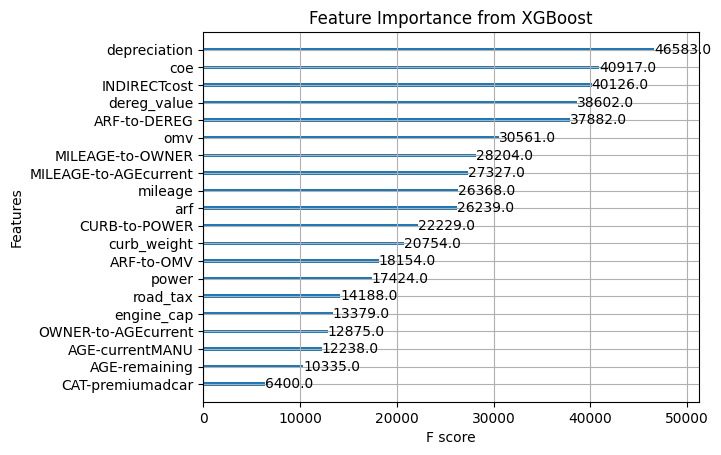

In [28]:
xgboost.plot_importance(ENCODED_xbg_model, importance_type='weight', max_num_features=20)  # You can also use 'gain' or 'cover'
plt.title("Feature Importance from XGBoost")
plt.show()

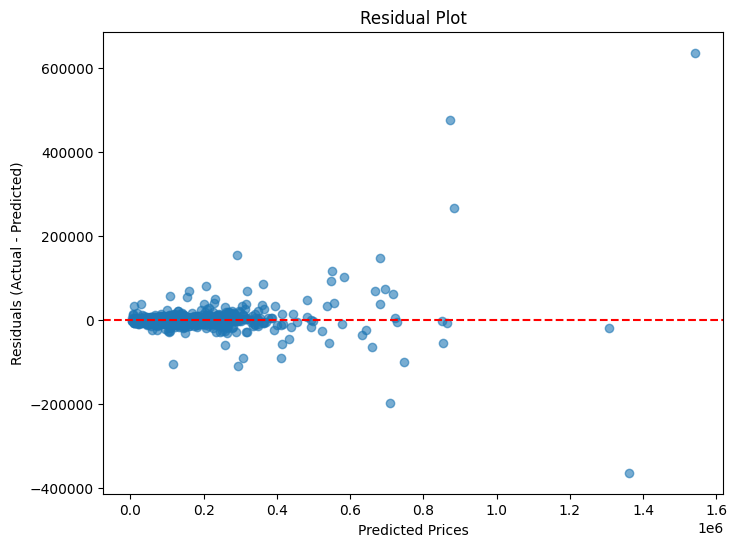

In [36]:
y_pred = ENCODED_xbg_model.predict(train_df_eval[ENCODED_feature_list])
residuals = train_df_eval[target] - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

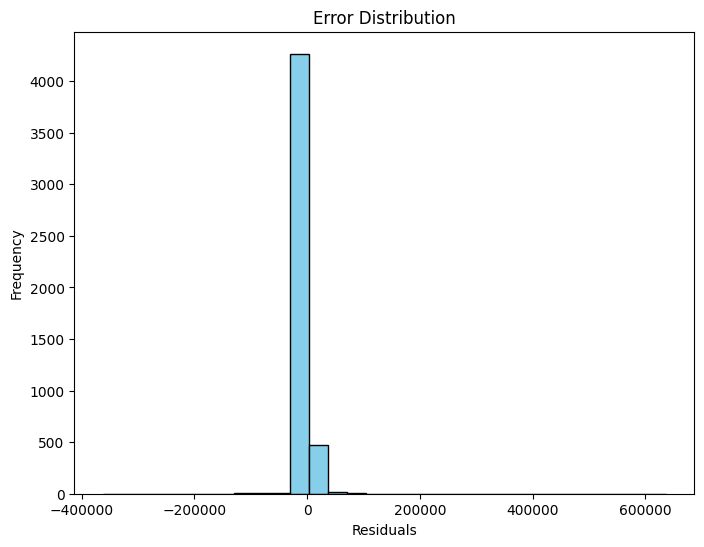

In [37]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', color='skyblue')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()

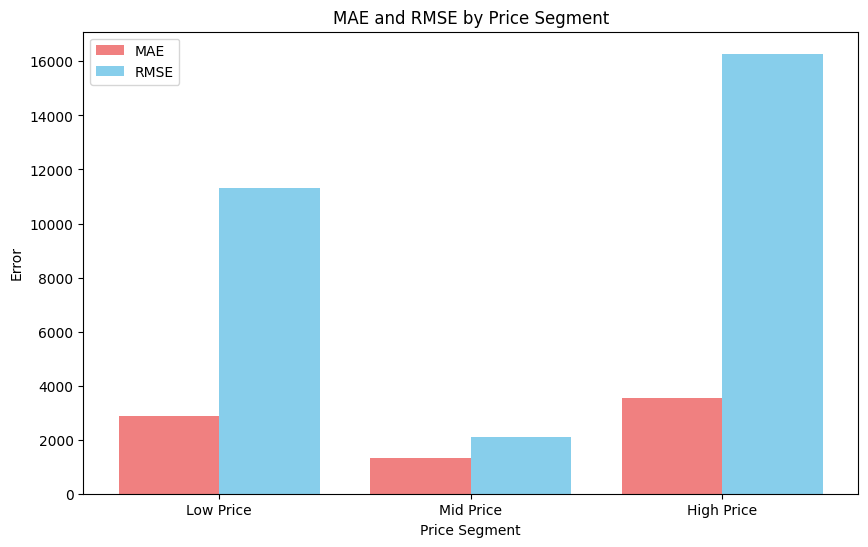

In [42]:
low_price = train_df_eval[target][train_df_eval[target] < 15000]
mid_price = train_df_eval[target][(train_df_eval[target] >= 15000) & (train_df_eval[target] < 30000)]
high_price = train_df_eval[target][train_df_eval[target] >= 30000]

low_pred = y_pred[train_df_eval[target] < 15000]
mid_pred = y_pred[(train_df_eval[target] >= 15000) & (train_df_eval[target] < 30000)]
high_pred = y_pred[train_df_eval[target] >= 30000]

# Calculate MAE and RMSE for each segment
segments = ['Low Price', 'Mid Price', 'High Price']
mae_values = [
    mean_absolute_error(low_price, low_pred),
    mean_absolute_error(mid_price, mid_pred),
    mean_absolute_error(high_price, high_pred)
]
rmse_values = [
    root_mean_squared_error(low_price, low_pred),
    root_mean_squared_error(mid_price, mid_pred),
    root_mean_squared_error(high_price, high_pred)
]

x = np.arange(len(segments))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, mae_values, width=0.4, label='MAE', color='lightcoral')
plt.bar(x + 0.2, rmse_values, width=0.4, label='RMSE', color='skyblue')
plt.xticks(x, segments)
plt.xlabel("Price Segment")
plt.ylabel("Error")
plt.title("MAE and RMSE by Price Segment")
plt.legend()
plt.show()